In [1]:
#Importing necessary libraries for deep learning, data loading, plotting, and evaluation
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [2]:
#Implement MLP with customizable hidden layers and activation options (Problem 1 - Part 1)
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, activation='ReLU'):
        super().__init__()
        self.hidden_layers = nn.ModuleList()
        all_sizes = [input_size] + hidden_sizes
        for i in range(len(hidden_sizes)):
            self.hidden_layers.append(nn.Linear(all_sizes[i], all_sizes[i+1]))
        self.output_layer = nn.Linear(all_sizes[-1], output_size)
        activations = {
            'ReLU': nn.ReLU(),
            'Sigmoid': nn.Sigmoid(),
            'Tanh': nn.Tanh(),
            'LeakyReLU': nn.LeakyReLU()
        }
        self.activation = activations.get(activation, nn.ReLU())

    def forward(self, x):
        for layer in self.hidden_layers:
            x = self.activation(layer(x))
        return torch.softmax(self.output_layer(x), dim=1)


In [3]:
#Define model training and evaluation procedures with GPU support (Problem 1 - Part 3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for images, labels in loader:
        images = images.view(images.size(0), -1).to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += images.size(0)
    return total_loss / total, correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.view(images.size(0), -1).to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += images.size(0)
    return total_loss / total, correct / total


In [4]:
#Load and prepare the classic MNIST dataset from pickle file (Problem 1 - Part 4)
with open('mnist.pkl', 'rb') as f:
    mnist_data = pickle.load(f)

X_train_full = torch.FloatTensor(mnist_data['training_images'])
y_train_full = torch.LongTensor(mnist_data['training_labels'])
X_test = torch.FloatTensor(mnist_data['test_images'])
y_test = torch.LongTensor(mnist_data['test_labels'])

# Normalize images
X_train_full /= 255.0
X_test /= 255.0

num_train = 50000
X_train = X_train_full[:num_train]
y_train = y_train_full[:num_train]
X_valid = X_train_full[num_train:]
y_valid = y_train_full[num_train:]

train_dataset_mnist = TensorDataset(X_train, y_train)
valid_dataset_mnist = TensorDataset(X_valid, y_valid)
test_dataset_mnist = TensorDataset(X_test, y_test)

batch_size = 64
train_loader_mnist = DataLoader(train_dataset_mnist, batch_size=batch_size, shuffle=True)
valid_loader_mnist = DataLoader(valid_dataset_mnist, batch_size=batch_size, shuffle=False)
test_loader_mnist = DataLoader(test_dataset_mnist, batch_size=batch_size, shuffle=False)


In [5]:
#Load and prepare Fashion MNIST dataset using torchvision (Problem 1 - Part 4)
transform = transforms.Compose([transforms.ToTensor()])
dataset_fashion = FashionMNIST('./data', train=True, download=True, transform=transform)
test_set_fashion = FashionMNIST('./data', train=False, download=True, transform=transform)

train_size = int(0.8 * len(dataset_fashion))
valid_size = len(dataset_fashion) - train_size
train_set_fashion, valid_set_fashion = random_split(dataset_fashion, [train_size, valid_size])

train_loader_fashion = DataLoader(train_set_fashion, batch_size=batch_size, shuffle=True)
valid_loader_fashion = DataLoader(valid_set_fashion, batch_size=batch_size, shuffle=False)
test_loader_fashion = DataLoader(test_set_fashion, batch_size=batch_size, shuffle=False)


In [6]:
#Run training, validation, model saving, and plotting for any dataset (Parts 2, 3 and 4)
#Integrates optimizer choice (Adam, AdaGrad, SGD), trains model over epochs, tracks and plots accuracy, 
#saves best model by validation accuracy. Covers optimizer selection and training visualization fully.
def run_training_experiment(train_loader, valid_loader, test_loader, model_name):
    input_size = 28*28
    hidden_sizes = [128, 64]
    output_size = 10
    activation = 'ReLU'
    learning_rate = 0.001
    num_epochs = 20
    optimizer_name = 'Adam'

    model = MLP(input_size, hidden_sizes, output_size, activation).to(device)
    criterion = nn.CrossEntropyLoss()

    if optimizer_name == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'Adagrad':
        optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    train_accs, valid_accs = [], []
    best_val_acc = 0

    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate(model, valid_loader, criterion, device)

        train_accs.append(train_acc)
        valid_accs.append(val_acc)

        print(f"{model_name} Epoch {epoch+1}/{num_epochs} Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f'best_model_{model_name}.pth')

    # Plot training and validation accuracy
    plt.figure()
    plt.plot(range(1, num_epochs + 1), train_accs, label="Train Accuracy")
    plt.plot(range(1, num_epochs + 1), valid_accs, label="Validation Accuracy")
    plt.title(f"{model_name}: Train vs Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig(f"{model_name}_accuracy.png")
    plt.show()

    # Load best model and evaluate test
    model.load_state_dict(torch.load(f'best_model_{model_name}.pth'))
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    print(f"{model_name} Test Accuracy: {test_acc:.4f}")

    all_preds, all_labels = [], []
    model.eval()
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.view(imgs.size(0), -1).to(device)
            outputs = model(imgs)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.savefig(f'{model_name}_confusion_matrix.png')
    plt.show()


MNIST Epoch 1/20 Train Acc: 0.7446, Val Acc: 0.8334
MNIST Epoch 2/20 Train Acc: 0.8552, Val Acc: 0.9310
MNIST Epoch 3/20 Train Acc: 0.9411, Val Acc: 0.9557
MNIST Epoch 4/20 Train Acc: 0.9545, Val Acc: 0.9413
MNIST Epoch 5/20 Train Acc: 0.9631, Val Acc: 0.9642
MNIST Epoch 6/20 Train Acc: 0.9687, Val Acc: 0.9654
MNIST Epoch 7/20 Train Acc: 0.9716, Val Acc: 0.9693
MNIST Epoch 8/20 Train Acc: 0.9755, Val Acc: 0.9688
MNIST Epoch 9/20 Train Acc: 0.9773, Val Acc: 0.9703
MNIST Epoch 10/20 Train Acc: 0.9794, Val Acc: 0.9688
MNIST Epoch 11/20 Train Acc: 0.9809, Val Acc: 0.9715
MNIST Epoch 12/20 Train Acc: 0.9829, Val Acc: 0.9725
MNIST Epoch 13/20 Train Acc: 0.9835, Val Acc: 0.9723
MNIST Epoch 14/20 Train Acc: 0.9840, Val Acc: 0.9726
MNIST Epoch 15/20 Train Acc: 0.9848, Val Acc: 0.9748
MNIST Epoch 16/20 Train Acc: 0.9864, Val Acc: 0.9745
MNIST Epoch 17/20 Train Acc: 0.9864, Val Acc: 0.9723
MNIST Epoch 18/20 Train Acc: 0.9881, Val Acc: 0.9740
MNIST Epoch 19/20 Train Acc: 0.9882, Val Acc: 0.9745
MN

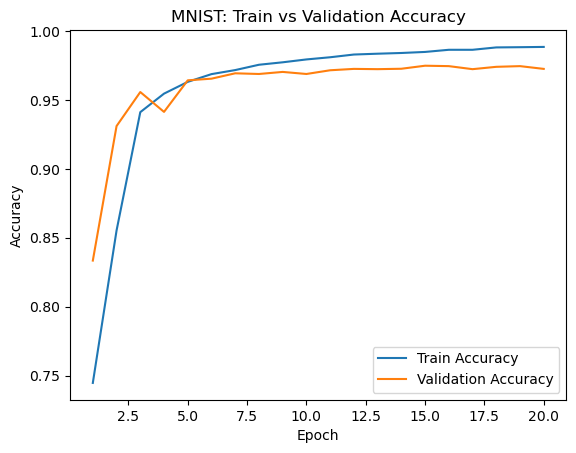

MNIST Test Accuracy: 0.9748


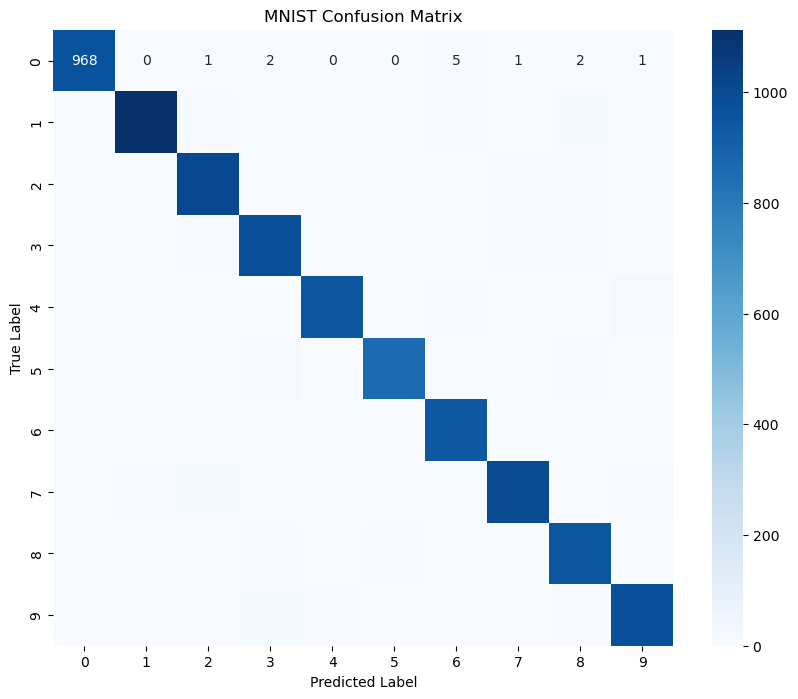

In [7]:
#"Execute training and evaluation on MNIST dataset (Parts 1, 2, 3, 4)
run_training_experiment(train_loader_mnist, valid_loader_mnist, test_loader_mnist, "MNIST")


Fashion_MNIST Epoch 1/20 Train Acc: 0.7616, Val Acc: 0.8279
Fashion_MNIST Epoch 2/20 Train Acc: 0.8333, Val Acc: 0.8307
Fashion_MNIST Epoch 3/20 Train Acc: 0.8452, Val Acc: 0.8396
Fashion_MNIST Epoch 4/20 Train Acc: 0.8528, Val Acc: 0.8447
Fashion_MNIST Epoch 5/20 Train Acc: 0.8582, Val Acc: 0.8554
Fashion_MNIST Epoch 6/20 Train Acc: 0.8637, Val Acc: 0.8585
Fashion_MNIST Epoch 7/20 Train Acc: 0.8674, Val Acc: 0.8621
Fashion_MNIST Epoch 8/20 Train Acc: 0.8685, Val Acc: 0.8652
Fashion_MNIST Epoch 9/20 Train Acc: 0.8713, Val Acc: 0.8596
Fashion_MNIST Epoch 10/20 Train Acc: 0.8724, Val Acc: 0.8639
Fashion_MNIST Epoch 11/20 Train Acc: 0.8782, Val Acc: 0.8560
Fashion_MNIST Epoch 12/20 Train Acc: 0.8805, Val Acc: 0.8661
Fashion_MNIST Epoch 13/20 Train Acc: 0.8836, Val Acc: 0.8603
Fashion_MNIST Epoch 14/20 Train Acc: 0.8832, Val Acc: 0.8750
Fashion_MNIST Epoch 15/20 Train Acc: 0.8847, Val Acc: 0.8749
Fashion_MNIST Epoch 16/20 Train Acc: 0.8868, Val Acc: 0.8789
Fashion_MNIST Epoch 17/20 Train A

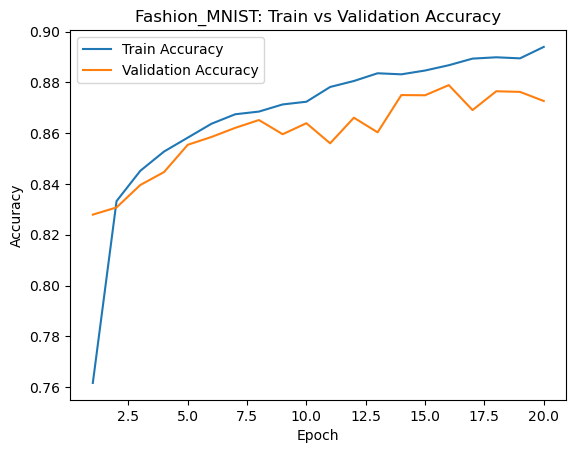

Fashion_MNIST Test Accuracy: 0.8693


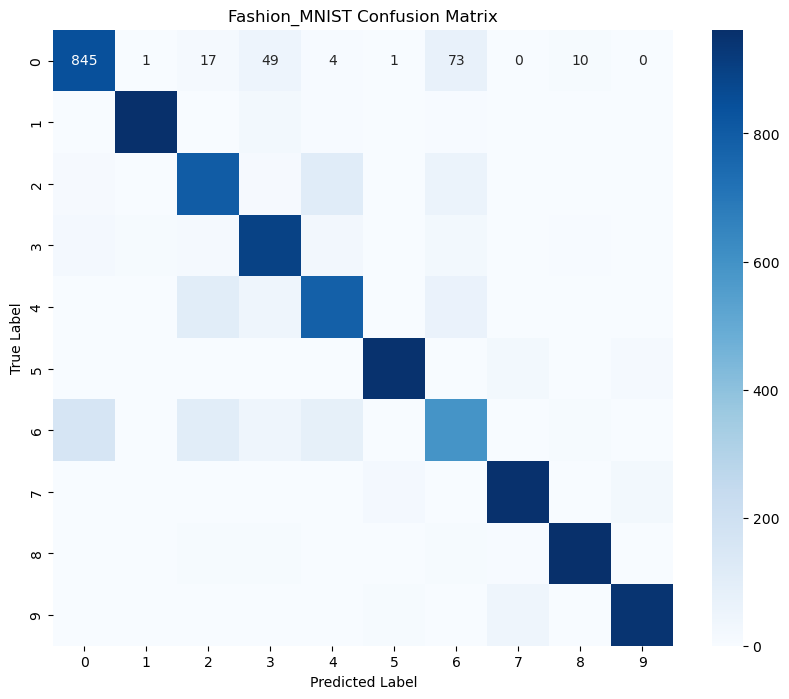

In [8]:
#Execute training and evaluation on Fashion MNIST dataset (Parts 1, 2, 3, 4)
run_training_experiment(train_loader_fashion, valid_loader_fashion, test_loader_fashion, "Fashion_MNIST")
